In [10]:
import cv2
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from skimage import restoration
from sklearn.cluster import KMeans
from sklearn.linear_model import RANSACRegressor
import ipywidgets as widgets
from IPython.display import display

IMG_ORIGINAL = None
IMG_INVERTED = None
IMG_BLURRED = None
IMG_SUBTRACTED = None
BINARY_IMG = None
ROW_PEAKS = None
COL_PEAKS = None
GRID_SHAPE = None


np.set_printoptions(threshold=sys.maxsize)    

In [11]:
## Helper funcions
def load_and_convert_image(image_path):
    """Load image and convert to grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or could not be loaded. Check the file path.")
    print(f"Image loaded successfully. Shape: {img.shape}, dtype: {img.dtype}")
    return img

def invert_image(img):
    """Invert image colors"""
    img_inv = cv2.bitwise_not(img)
    return img_inv

def apply_blur(img, kernel_size=(3,3)):
    """Apply blur to image"""
    return cv2.blur(img, kernel_size)

def subtract_background(img, radius=25):
    """Subtract background using rolling ball algorithm"""
    background = restoration.rolling_ball(img, radius=radius)
    return img - background

def apply_thresholding(img, dot_diameter):
    """Apply adaptive thresholding to binarize image"""
    block_size = int(dot_diameter * 2) + 1  # Ensure odd number
    return cv2.adaptiveThreshold(img, 255, 
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, block_size, 2)

def apply_morphological_cleanup(thresh_img):
    """Clean up image using morphological operations"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    return cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernel)

def show_image(img, title="Image", cmap='gray', figsize=(8, 8)):
    """Helper function to display an image"""
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_results_dataframe(results):
    """Create and normalize results dataframe"""
    df = pd.DataFrame(results)
    if len(df) > 0:
        df['normalized_density'] = df.integrated_density / df.integrated_density.max()
    else:
        df['normalized_density'] = np.nan
    return df

In [12]:
## Grid Detection Functions
def detect_grid_lines(binary_img, expected_rows=14, expected_cols=26, min_distance=8, smoothing_window=5, regularize_peaks=False, debug=False):
    """
    Detect grid lines using projection profiles
    
    Parameters:
    -----------
    binary_img : numpy.ndarray
        Binary image with dots (white) on background (black)
    expected_rows : int
        Expected number of rows in the grid
    expected_cols : int
        Expected number of columns in the grid
    min_distance : int
        Minimum distance between peaks (grid lines)
    smoothing_window : int
        Window sie for smoothing projection profiles
    debug : bool
        If True, show debug visualizations
        
    Returns:
    --------
    row_peaks : numpy.ndarray
        Y-coordinates of detected row centers
    col_peaks : numpy.ndarray
        X-coordinates of detected column centers
    """
    # Calculate projection profiles
    row_profile = np.sum(binary_img, axis=1)  # Sum across rows (horizontal projection)
    col_profile = np.sum(binary_img, axis=0)  # Sum across columns (vertical projection)
    
    # Smooth the profiles to reduce noise
    from scipy.signal import savgol_filter
    if len(row_profile) > smoothing_window:
        row_profile_smooth = savgol_filter(row_profile, smoothing_window, 3)
        col_profile_smooth = savgol_filter(col_profile, smoothing_window, 3)
    else:
        row_profile_smooth = row_profile
        col_profile_smooth = col_profile
    
    # Detect peaks in the profiles
    from scipy.signal import find_peaks
    row_peaks, _ = find_peaks(row_profile_smooth, distance=min_distance)
    col_peaks, _ = find_peaks(col_profile_smooth, distance=min_distance)

    
    if regularize_peaks:
        row_peaks = regularize_peaks(row_peaks, expected_rows)
        col_peaks = regularize_peaks(col_peaks, expected_cols)

    # Ensure we have exactly the expected number of peaks
    row_peaks = np.sort(row_peaks)[:expected_rows]
    col_peaks = np.sort(col_peaks)[:expected_cols]
    
    
    # If too many or too few peaks are found, try adaptive thresholding
    if len(row_peaks) < expected_rows or len(row_peaks) > expected_rows * 1.5:
        # Sort peaks by prominence and take the top expected_rows
        row_peaks, properties = find_peaks(row_profile_smooth, distance=min_distance, height=0)
        if len(row_peaks) >= expected_rows:
            # Sort by peak height
            sorted_indices = np.argsort(-properties["peak_heights"])
            row_peaks = row_peaks[sorted_indices[:expected_rows]]
            row_peaks = np.sort(row_peaks)  # Sort by position again
    
    if len(col_peaks) < expected_cols or len(col_peaks) > expected_cols * 1.5:
        # Sort peaks by prominence and take the top expected_cols
        col_peaks, properties = find_peaks(col_profile_smooth, distance=min_distance, height=0)
        if len(col_peaks) >= expected_cols:
            # Sort by peak height
            sorted_indices = np.argsort(-properties["peak_heights"])
            col_peaks = col_peaks[sorted_indices[:expected_cols]]
            col_peaks = np.sort(col_peaks)  # Sort by position again

    
    if debug:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        
        # Show horizontal projection profile
        axs[0, 0].plot(row_profile)
        axs[0, 0].plot(row_profile_smooth, 'r-')
        axs[0, 0].plot(row_peaks, row_profile_smooth[row_peaks], 'go')
        axs[0, 0].set_title(f"Horizontal Projection (Detected {len(row_peaks)} rows)")
        axs[0, 0].set_xlabel("Row Index")
        axs[0, 0].set_ylabel("Sum of Pixels")
        
        # Show vertical projection profile
        axs[0, 1].plot(col_profile)
        axs[0, 1].plot(col_profile_smooth, 'r-')
        axs[0, 1].plot(col_peaks, col_profile_smooth[col_peaks], 'go')
        axs[0, 1].set_title(f"Vertical Projection (Detected {len(col_peaks)} columns)")
        axs[0, 1].set_xlabel("Column Index")
        axs[0, 1].set_ylabel("Sum of Pixels")
        
        # Show the image with row lines
        axs[1, 0].imshow(binary_img, cmap='gray')
        for peak in row_peaks:
            axs[1, 0].axhline(y=peak, color='r', linewidth=1)
        axs[1, 0].set_title("Detected Row Lines")
        
        # Show the image with column lines
        axs[1, 1].imshow(binary_img, cmap='gray')
        for peak in col_peaks:
            axs[1, 1].axvline(x=peak, color='b', linewidth=1)
        axs[1, 1].set_title("Detected Column Lines")
        
        plt.tight_layout()
        plt.show()

    
    
    return row_peaks, col_peaks

def regularize_peaks(peaks, expected_count):
    """Adjust peaks to be evenly spaced using RANSAC regression"""
    if len(peaks) < 2:
        return peaks  # Can't fit a line
    
    # Sort peaks and create indices
    sorted_peaks = np.sort(peaks)
    indices = np.arange(len(sorted_peaks)).reshape(-1, 1)
    
    # Robust linear regression
    ransac = RANSACRegressor()
    ransac.fit(indices, sorted_peaks)
    adjusted_peaks = ransac.predict(indices)
    
    return adjusted_peaks.astype(int)

def create_grid_from_peaks(row_peaks, col_peaks):
    """
    Create grid coordinates from detected row and column peaks
    
    Parameters:
    -----------
    row_peaks : numpy.ndarray
        Y-coordinates of detected rows
    col_peaks : numpy.ndarray
        X-coordinates of detected columns
        
    Returns:
    --------
    grid_coords : numpy.ndarray
        Array of shape (len(row_peaks)*len(col_peaks), 2) containing (x,y) coordinates
        of all grid points
    """
    # Create meshgrid from peak positions
    col_mesh, row_mesh = np.meshgrid(col_peaks, row_peaks)
    
    # Combine into grid coordinates
    grid_coords = np.column_stack((col_mesh.flatten(), row_mesh.flatten()))
    
    return grid_coords   

def fit_grid_to_dots(binary_img, expected_rows=14, expected_cols=26, debug=False):
    """
    Fit a grid to dots in binary image using projection profile method
    
    Parameters:
    -----------
    binary_img : numpy.ndarray
        Binary image with dots (white) on background (black)
    expected_rows : int
        Expected number of rows in the grid
    expected_cols : int
        Expected number of columns in the grid
    debug : bool
        If True, show debug visualizations
        
    Returns:
    --------
    grid : list
        List of rows, where each row is a list of (x,y) tuples for dots
    grid_shape : tuple
        Tuple of (rows, cols) representing the shape of the detected grid
    row_peaks : numpy.ndarray
        Y-coordinates of detected row centers
    col_peaks : numpy.ndarray
        X-coordinates of detected column centers
    """
    # Detect grid lines using projection profiles
    row_peaks, col_peaks = detect_grid_lines(binary_img, 
                                           expected_rows=expected_rows, 
                                           expected_cols=expected_cols, 
                                           debug=debug)
    


    
    # Create a mesh grid of all intersection points
    grid_coords = create_grid_from_peaks(row_peaks, col_peaks)
    
    # Reshape to get a proper grid structure
    grid_points = grid_coords.reshape(len(row_peaks), len(col_peaks), 2)
    
    # Convert to the format expected by measure_intensities
    # (list of rows, where each row is a list of (x,y) tuples)
    grid = []
    for i in range(len(row_peaks)):
        row = []
        for j in range(len(col_peaks)):
            row.append((grid_points[i, j, 0], grid_points[i, j, 1]))
        grid.append(row)
        

    grid_shape = (len(row_peaks), len(col_peaks))
    return grid, grid_shape, row_peaks, col_peaks

def measure_grid_cell_intensities_by_gridlines(img_subtracted, row_peaks, col_peaks):
    """
    Measure intensities in grid cells where the grid lines themselves serve as boundaries
    
    Parameters:
    -----------
    img_subtracted : numpy.ndarray
        Background-subtracted image for intensity measurements
    row_peaks : numpy.ndarray
        Y-coordinates of detected row centers/grid lines
    col_peaks : numpy.ndarray
        X-coordinates of detected column centers/grid lines
        
    Returns:
    --------
    results : list of dict
        List of dictionaries containing cell measurements
    """
    results = []
    
    # We need at least 2 rows and 2 columns to form a cell
    if len(row_peaks) < 2 or len(col_peaks) < 2:
        return results
    
    # Measure intensity in each cell formed by four grid lines
    for row_idx in range(len(row_peaks) - 1):
        for col_idx in range(len(col_peaks) - 1):
            # Get cell boundaries directly from grid lines
            y1 = row_peaks[row_idx]     # top boundary = current row grid line
            y2 = row_peaks[row_idx + 1] # bottom boundary = next row grid line
            x1 = col_peaks[col_idx]     # left boundary = current column grid line
            x2 = col_peaks[col_idx + 1] # right boundary = next column grid line
            
            # Cell center is midpoint of the four grid lines
            x_center = (x1 + x2) // 2
            y_center = (y1 + y2) // 2
            
            # Extract cell region (the area between grid lines)
            cell_region = img_subtracted[y1:y2, x1:x2]
            
            # Skip if cell is empty (this shouldn't happen with valid grid lines)
            if cell_region.size == 0:
                continue
            
            # Calculate metrics
            integrated_density = np.sum(cell_region)
            mean_intensity = np.mean(cell_region)
            cell_area = cell_region.size
            
            # Store results - note the row/col indices are 1-based for consistency
            results.append({
                "row": row_idx + 1,
                "col": col_idx + 1,
                "x": x_center,
                "y": y_center,
                "x1": x1,
                "y1": y1,
                "x2": x2,
                "y2": y2,
                "integrated_density": integrated_density,
                "mean_intensity": mean_intensity,
                "cell_area": cell_area
            })
    
    return results


In [13]:
## Visualization Functions
def visualize_grid_only(img_subtracted, row_peaks, col_peaks, line_thickness=1, figsize=(15, 15)):
    """
    Visualize just the grid lines overlaid on the background-subtracted image
    
    Parameters:
    -----------
    img_subtracted : numpy.ndarray
        Background-subtracted image
    row_peaks : numpy.ndarray
        Y-coordinates of row centers
    col_peaks : numpy.ndarray
        X-coordinates of column centers
    line_thickness : int
        Thickness of grid lines
    figsize : tuple
        Figure size for matplotlib display
    """
    # Make sure we're working with a copy to preserve the original
    img_for_display = img_subtracted.copy()
    
    # Convert to color image for overlaying white grid lines
    vis_img = cv2.cvtColor(img_for_display, cv2.COLOR_GRAY2BGR)
    
    # Draw grid lines directly on the image (white color)
    for y in row_peaks:
        cv2.line(vis_img, (0, int(y)), (vis_img.shape[1], int(y)), (255, 255, 255), line_thickness)
    
    for x in col_peaks:
        cv2.line(vis_img, (int(x), 0), (int(x), vis_img.shape[0]), (255, 255, 255), line_thickness)
    
    # Display the result using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grid Lines ({len(row_peaks)}×{len(col_peaks)} grid)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return vis_img

def visualize_grid_with_values(img_subtracted, row_peaks, col_peaks, df, figsize=(30, 30)):
    """
    Visualize grid with integrated density values and proper labeling
    
    Parameters:
    -----------
    img_subtracted : numpy.ndarray
        Background-subtracted image
    row_peaks : numpy.ndarray
        Y-coordinates of row centers (including border)
    col_peaks : numpy.ndarray
        X-coordinates of column centers (including border)
    df : pandas.DataFrame
        DataFrame containing measurement results
    figsize : tuple
        Figure size for visualization
    """
    plt.figure(figsize=figsize)
    plt.imshow(img_subtracted, cmap='gray')
    
    # Draw grid lines through the centers (matching visualize_grid_only)
    for y in row_peaks:
        plt.axhline(y=y, color='white', alpha=0.7, linewidth=1)
    for x in col_peaks:
        plt.axvline(x=x, color='white', alpha=0.7, linewidth=1)
    
    # Annotate values with proper indexing
    for _, row in df.iterrows():
        try:
            # Convert 1-based indices to 0-based for array access
            row_idx = int(row['row']) - 1
            col_idx = int(row['col']) - 1
            
            # Check array bounds
            if row_idx < 0 or row_idx >= len(row_peaks) or col_idx < 0 or col_idx >= len(col_peaks):
                continue
                
            # Get cell center from the peaks arrays
            x_center = col_peaks[col_idx]
            y_center = row_peaks[row_idx]
            
            # Add annotation
            plt.text(x_center, y_center, f"{row['integrated_density']:.0f}", 
                     color='yellow', fontsize=8, ha='center', va='center',
                     bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))
        except (ValueError, KeyError, IndexError) as e:
            # Skip any problematic entries and print debug info
            print(f"Skipping label at row={row['row']}, col={row['col']}: {e}")
            continue

    # Add row labels (a-j)
    for i in range(min(10, len(row_peaks))):
        y = row_peaks[i]
        plt.text(-20, y, chr(97 + i),  # 97 = 'a' in ASCII
                 color='white', fontsize=12, ha='right', va='center')

    # Add column labels (1-24)
    for j in range(min(24, len(col_peaks))):
        x = col_peaks[j]
        plt.text(x, -20, str(j+1),
                 color='white', fontsize=12, ha='center', va='bottom')

    plt.title("Dot Blot Analysis - Grid with Integrated Density Values")
    plt.axis('off')
    plt.show()

def print_cytokine_array_results(df, metric="integrated_density", filter_borders=False):
    """
    Print the cytokine array results in a clean table format:
    - Rows labeled as letters (starting from 'a')
    - Columns labeled as numbers (starting from 1)
    - Option to include or exclude border cells
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 
        



    metric : str
        Name of the metric to display (default: "integrated_density")
    filter_borders : bool
        Whether to filter out border cells (first/last row, first/last column)
    """
    # Get the grid dimensions
    max_row = df['row'].max()
    max_col = df['col'].max()
    
    # Print grid dimensions for debugging
    print(f"Original grid: {max_row} rows × {max_col} columns")
    
    # Filter borders only if requested
    if filter_borders:
        inner_df = df[(df['row'] > 1) & (df['row'] < max_row) & 
                      (df['col'] > 1) & (df['col'] < max_col)].copy()
    else:
        inner_df = df.copy()  # Use all rows and columns
    
    # Map row numbers to letters (starting with 'a' for row 1)
    # Row 1 → 'a', Row 2 → 'b', etc.
    row_labels = {i: chr(97 + (i-1)) for i in range(1, max_row+1)}
    inner_df['row_label'] = inner_df['row'].map(row_labels)
    
    # Use actual column numbers (starting with 1)
    inner_df['col_label'] = inner_df['col']
    
    # Reshape the data for pretty printing
    pivot_table = inner_df.pivot(index='row_label', columns='col_label', values=metric)
    
    # Print dimensions of data
    print(f"Display grid: {len(pivot_table.index)} rows × {len(pivot_table.columns)} columns")
    
    # Print header
    print(f"\nCytokine Array {metric.replace('_', ' ').title()} Values:")
    print("-" * 100)  # Wider separator for more columns
    
    # Print column headers with better spacing
    header = "     "
    for col in sorted(pivot_table.columns):
        header += f"{col:8d}"
    print(header)
    print("-" * 100)  # Wider separator for more columns
    
    # Print each row with row label (sort alphabetically)
    for row_label in sorted(pivot_table.index):
        row_data = pivot_table.loc[row_label]
        row_str = f"{row_label:3s} | "
        for col in sorted(pivot_table.columns):
            row_str += f"{row_data[col]:8.0f}"
        print(row_str)
    
    print("-" * 100)  # Wider separator for more columns


In [14]:
def analyze_dot_blot(image_path, 
                    # Basic settings
                    dot_diameter=10, 
                    expected_rows=11, 
                    expected_cols=23,
                    
                    # Image processing settings
                    background_radius=25,
                    blur_kernel_size=(3,3),
                    apply_binary_threshold=False, 
                    
                    # Grid detection settings
                    min_peak_distance=8,
                    peak_smoothing_window=5,
                    regularize_grid=False,
                    
                    # Visualization settings
                    show_density_values=True, 
                    line_thickness=1,
                    debug_grid=True):
    """
    Analyze cytokine dot blot images with automated grid detection and quantification.
    
    Updates global variables for later manual adjustments.
    """
    global IMG_ORIGINAL, IMG_INVERTED, IMG_BLURRED, IMG_SUBTRACTED, BINARY_IMG
    global ROW_PEAKS, COL_PEAKS, GRID_SHAPE
    
    # Print analysis parameters
    print(f"Analyzing dot blot with {expected_rows}×{expected_cols} grid, dot diameter: {dot_diameter}px")
    print(f"Background radius: {background_radius}, blur kernel: {blur_kernel_size}")
    
    # 1. Load and convert image
    IMG_ORIGINAL = load_and_convert_image(image_path)
    show_image(IMG_ORIGINAL, "Original Image")
    
    # 2. Invert image colors (dots become white on black background)
    IMG_INVERTED = invert_image(IMG_ORIGINAL)
    
    # 3. Apply blur to reduce noise
    IMG_BLURRED = apply_blur(IMG_INVERTED, kernel_size=blur_kernel_size)
    
    # 4. Subtract background for more uniform processing
    IMG_SUBTRACTED = subtract_background(IMG_BLURRED, radius=background_radius)
    show_image(IMG_SUBTRACTED, "Background-Subtracted Image")
    
    if apply_binary_threshold:        
        # 5. Apply thresholding to create binary image
        BINARY_IMG = apply_thresholding(IMG_ORIGINAL, dot_diameter)
        show_image(BINARY_IMG, "Thresholded Image")
        
        # 6. Apply morphological cleanup to reduce noise
        BINARY_IMG = apply_morphological_cleanup(BINARY_IMG)
    else:
        BINARY_IMG = IMG_ORIGINAL
    
    # 7. Detect grid lines
    ROW_PEAKS, COL_PEAKS = detect_grid_lines(
        BINARY_IMG,
        expected_rows=expected_rows,
        expected_cols=expected_cols,
        min_distance=min_peak_distance,
        smoothing_window=peak_smoothing_window,
        regularize_peaks=regularize_grid,
        debug=debug_grid
    )
    
    # Create the grid structure
    grid_coords = create_grid_from_peaks(ROW_PEAKS, COL_PEAKS)
    grid_points = grid_coords.reshape(len(ROW_PEAKS), len(COL_PEAKS), 2)
    
    grid = []
    for i in range(len(ROW_PEAKS)):
        row = []
        for j in range(len(COL_PEAKS)):
            row.append((grid_points[i, j, 0], grid_points[i, j, 1]))
        grid.append(row)
    
    GRID_SHAPE = (len(ROW_PEAKS), len(COL_PEAKS))
    print(f"Grid structure: {GRID_SHAPE[0]} rows x {GRID_SHAPE[1]} columns")
    
    # 8. Measure intensities using detected grid lines
    results = measure_grid_cell_intensities_by_gridlines(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS)
    
    # 9. Create and normalize results dataframe
    df = create_results_dataframe(results)
    
    # 10. Visualize results
    visualize_grid_only(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS, line_thickness=line_thickness)
    
    if show_density_values:
        visualize_grid_with_values(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS, df)
    
    return df

Analyzing dot blot with 11×25 grid, dot diameter: 10px
Background radius: 25, blur kernel: (3, 3)
Image loaded successfully. Shape: (148, 340), dtype: uint8


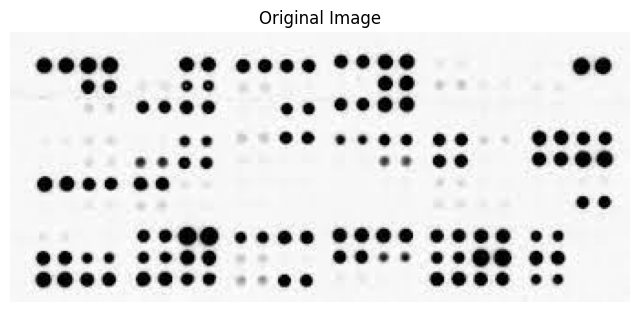

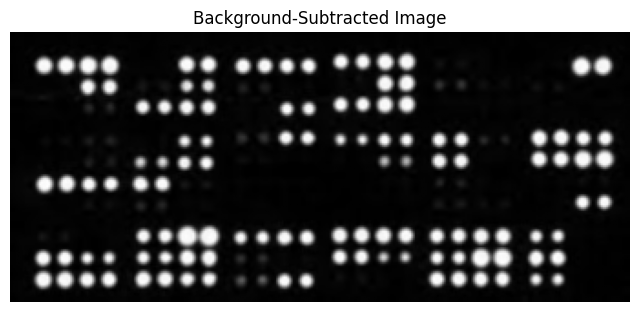

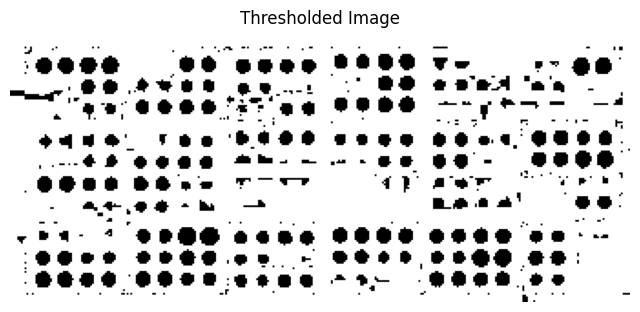

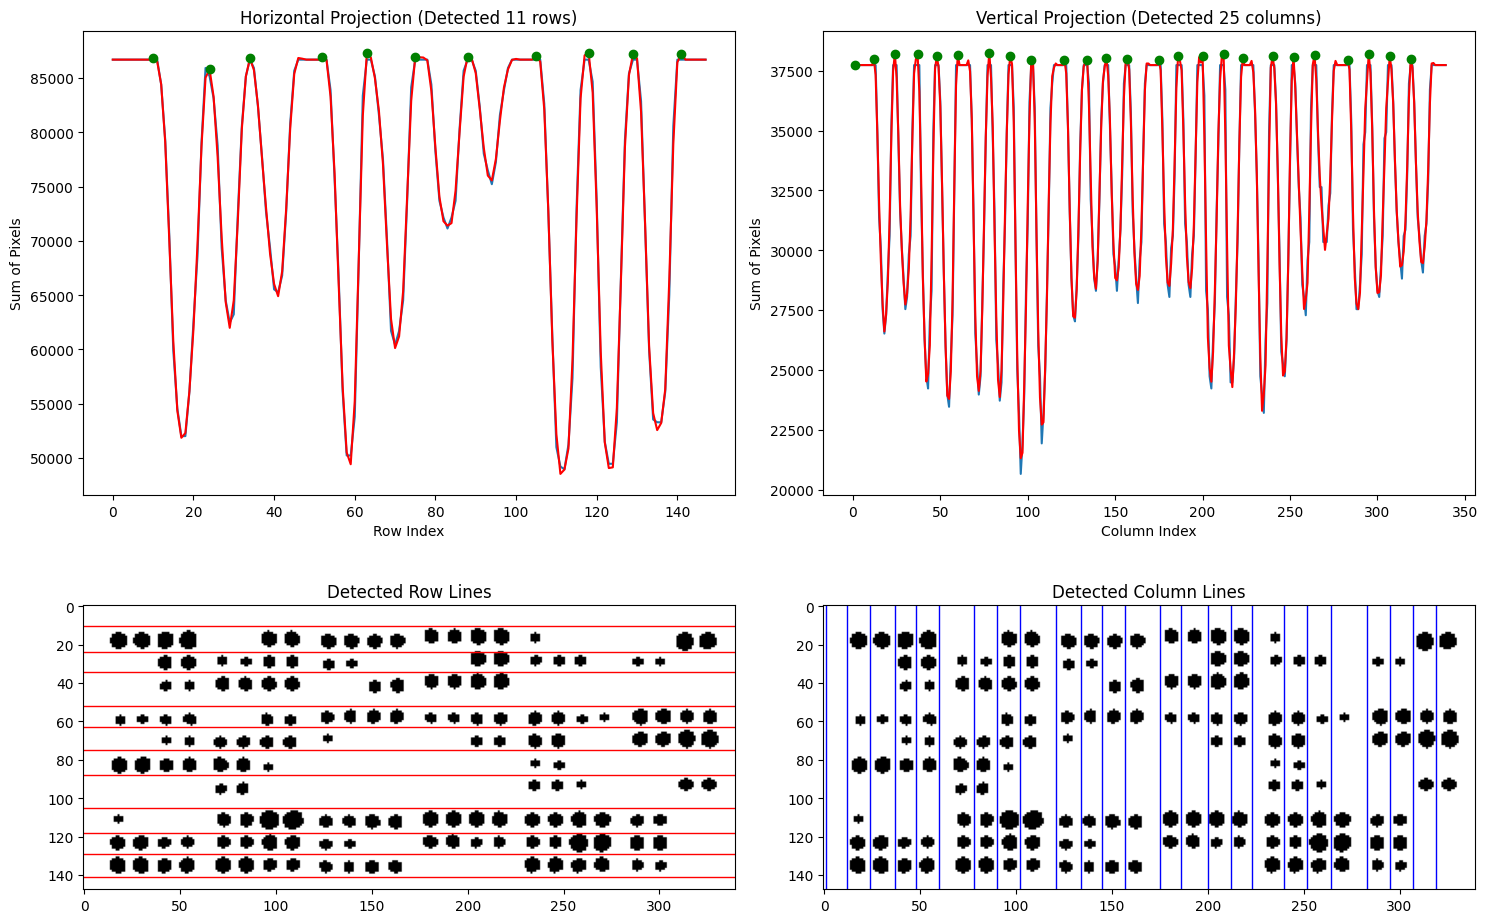

Grid structure: 11 rows x 25 columns


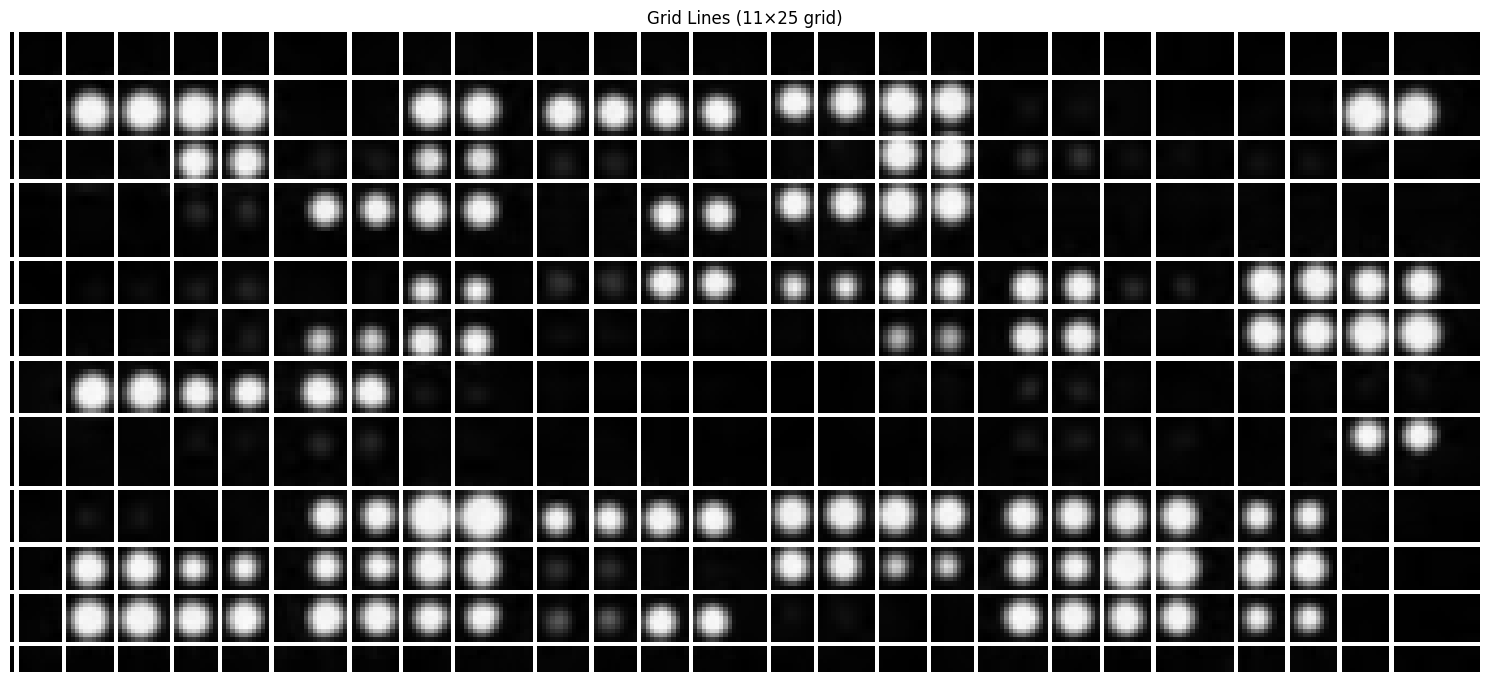

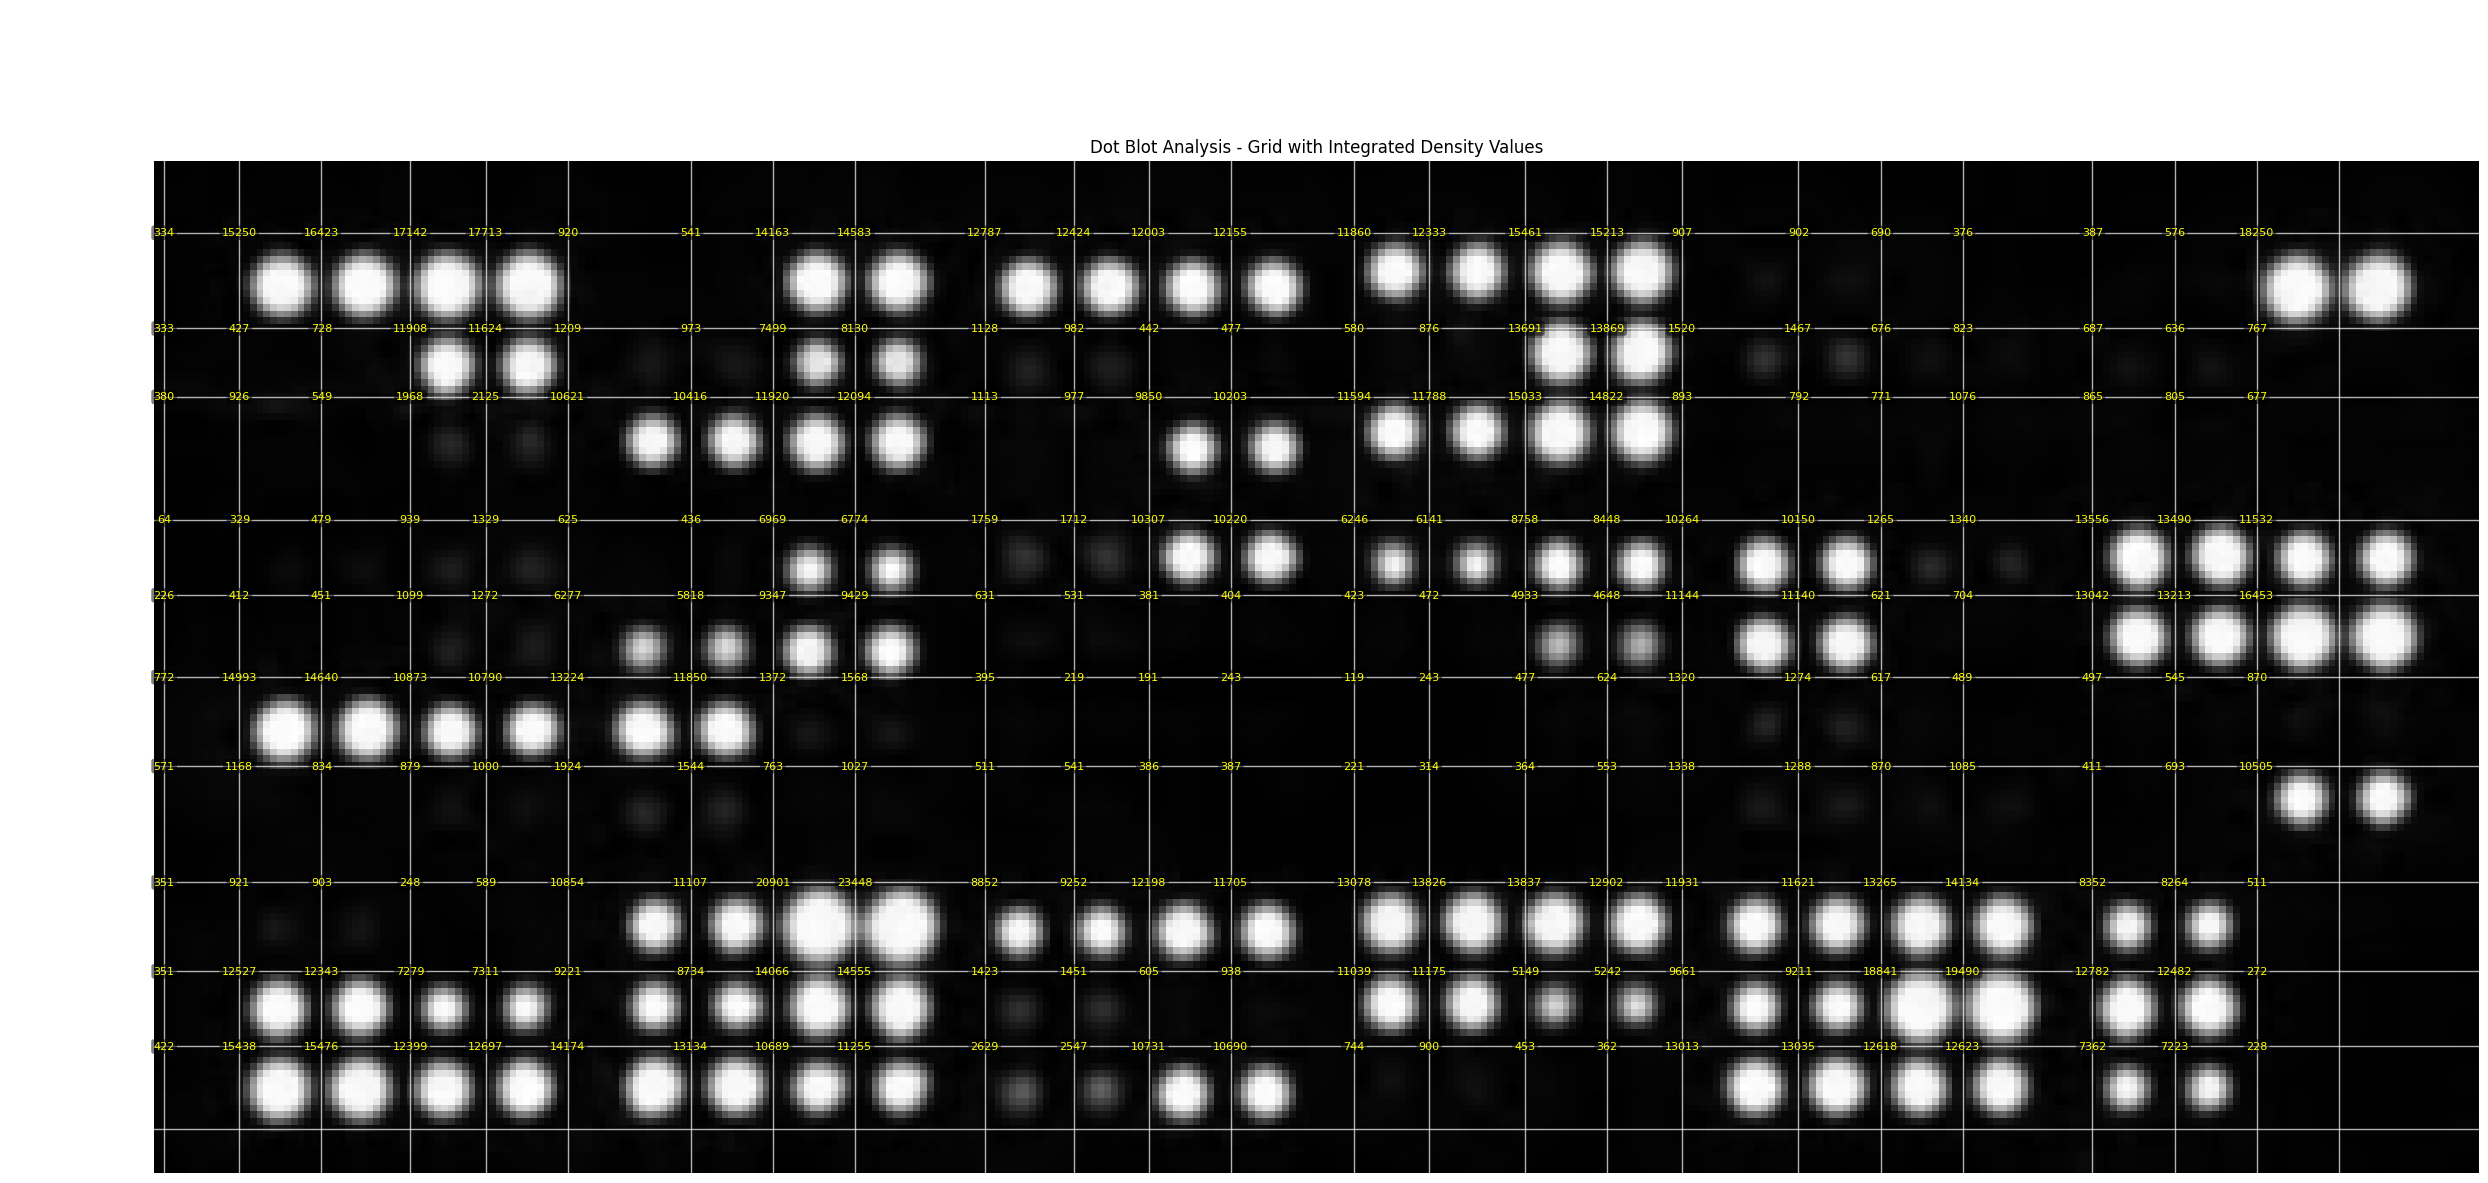

Original grid: 10 rows × 24 columns
Display grid: 10 rows × 24 columns

Cytokine Array Integrated Density Values:
----------------------------------------------------------------------------------------------------
            1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23      24
----------------------------------------------------------------------------------------------------
a   |      334   15250   16423   17142   17713     920     541   14163   14583   12787   12424   12003   12155   11860   12333   15461   15213     907     902     690     376     387     576   18250
b   |      333     427     728   11908   11624    1209     973    7499    8130    1128     982     442     477     580     876   13691   13869    1520    1467     676     823     687     636     767
c   |      380     926     549    1968    2125   10621   10416   11920   12094    1113  

In [15]:
# Image path
image_path = "./test_dots.jpeg"

# Basic settings
dot_diameter = 10
expected_rows = 11  # 10 data rows + 1 border
expected_cols = 25

# Image processing settings
background_radius = 25
blur_kernel_size = (3, 3)
apply_binary_threshold=True


# Grid detection settings
min_peak_distance = 8
peak_smoothing_window = 5
regularize_grid = False

# Visualization settings
show_density_values = True
cell_opacity = 0.2
filter_borders = False
line_thickness = 1
debug_grid = True

# Run analysis
results_df = analyze_dot_blot(image_path,
                     # Basic settings
                     dot_diameter=dot_diameter,
                     expected_rows=expected_rows, 
                     expected_cols=expected_cols,
                     
                     # Image processing settings
                     background_radius=background_radius,
                     blur_kernel_size=blur_kernel_size,
                     apply_binary_threshold=apply_binary_threshold,

                     
                     # Grid detection settings
                     min_peak_distance=min_peak_distance,
                     peak_smoothing_window=peak_smoothing_window,
                     regularize_grid=regularize_grid,
                     
                     # Visualization settings
                     show_density_values=show_density_values,
    
                     line_thickness=line_thickness,
                     debug_grid=debug_grid)

print_cytokine_array_results(results_df, filter_borders=filter_borders)

In [16]:
def interactive_grid_adjustment():
    """Create interactive sliders to manually adjust grid lines and add/remove columns/rows"""
    global ROW_PEAKS, COL_PEAKS, IMG_SUBTRACTED
    
    if IMG_SUBTRACTED is None or ROW_PEAKS is None or COL_PEAKS is None:
        print("Error: Run analyze_dot_blot first to initialize images and grid lines.")
        return
    
    # Create output widget to display the plot
    output_widget = widgets.Output()
    
    # Create sliders for each row line
    row_sliders = []
    for i, row_pos in enumerate(ROW_PEAKS):
        slider = widgets.IntSlider(
            value=int(row_pos),
            min=max(0, int(row_pos) - 50),
            max=min(IMG_SUBTRACTED.shape[0], int(row_pos) + 50),
            description=f'Row {i+1}',
            style={'description_width': '60px'},
            layout=widgets.Layout(width='400px')
        )
        row_sliders.append(slider)
    
    # Create sliders for each column line
    col_sliders = []
    for j, col_pos in enumerate(COL_PEAKS):
        slider = widgets.IntSlider(
            value=int(col_pos),
            min=max(0, int(col_pos) - 50),
            max=min(IMG_SUBTRACTED.shape[1], int(col_pos) + 50),
            description=f'Col {j+1}',
            style={'description_width': '60px'},
            layout=widgets.Layout(width='400px')
        )
        col_sliders.append(slider)
    
    # Create containers for sliders
    row_box = widgets.VBox(row_sliders, layout=widgets.Layout(
        overflow='auto',
        border='1px solid black',
        width='450px',
        height='300px'
    ))
    
    col_box = widgets.VBox(col_sliders, layout=widgets.Layout(
        overflow='auto',
        border='1px solid black',
        width='450px',
        height='300px'
    ))
    
    # Create buttons
    recalc_button = widgets.Button(
        description='Recalculate Densities',
        button_style='success',
        icon='check'
    )
    
    add_col_button = widgets.Button(
        description='Add Column',
        button_style='info',
        icon='plus',
        tooltip='Add a new column at the end'
    )
    
    delete_col_button = widgets.Button(
        description='Delete Last Column',
        button_style='warning',
        icon='minus',
        tooltip='Delete the last column'
    )

    add_row_button = widgets.Button(
        description='Add Row',
        button_style='info',
        icon='plus',
        tooltip='Add a new row at the end'
    )
    
    delete_row_button = widgets.Button(
        description='Delete Last Row',
        button_style='warning',
        icon='minus',
        tooltip='Delete the last row'
    )
    
    status_html = widgets.HTML("")
    
    # Handler for updating the display
    def update_display():
        with output_widget:
            output_widget.clear_output(wait=True)
            
            # Get slider values
            temp_row_peaks = ROW_PEAKS.copy()
            temp_col_peaks = COL_PEAKS.copy()
            
            for i, slider in enumerate(row_sliders):
                if i < len(temp_row_peaks):
                    temp_row_peaks[i] = slider.value
            
            for i, slider in enumerate(col_sliders):
                if i < len(temp_col_peaks):
                    temp_col_peaks[i] = slider.value
                    
            # Display image with grid lines
            plt.figure(figsize=(12, 12))
            plt.imshow(IMG_SUBTRACTED, cmap='gray')
            
            # Draw all grid lines
            for y in temp_row_peaks:
                plt.axhline(y=y, color='yellow', alpha=0.7, linewidth=1)
            for x in temp_col_peaks:
                plt.axvline(x=x, color='cyan', alpha=0.7, linewidth=1)
            
            plt.title(f"Grid Adjustment: {len(temp_row_peaks)} rows × {len(temp_col_peaks)} columns")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    
    # Helper function to create a new slider
    def create_slider(is_row, position, index):
        if is_row:
            return widgets.IntSlider(
                value=int(position),
                min=max(0, int(position) - 50),
                max=min(IMG_SUBTRACTED.shape[0], int(position) + 50),
                description=f'Row {index}',
                style={'description_width': '60px'},
                layout=widgets.Layout(width='400px')
            )
        else:
            return widgets.IntSlider(
                value=int(position),
                min=max(0, int(position) - 50),
                max=min(IMG_SUBTRACTED.shape[1], int(position) + 50),
                description=f'Col {index}',
                style={'description_width': '60px'},
                layout=widgets.Layout(width='400px')
            )
    
    # Register change handler for a slider
    def register_slider_handler(slider):
        slider.observe(on_slider_change, names='value')
        
    # Handler for adding a column with slider
    def add_column(button):
        global COL_PEAKS
        
        if len(COL_PEAKS) >= 1:
            # Calculate spacing based on average of existing columns
            spacing = 20  # default spacing
            if len(COL_PEAKS) >= 2:
                spacing = int(np.mean(np.diff(COL_PEAKS)))
                
            # Add new column at the end
            new_col = COL_PEAKS[-1] + spacing
            COL_PEAKS = np.append(COL_PEAKS, new_col)
            
            # Create and add slider for the new column
            new_slider = create_slider(is_row=False, position=new_col, index=len(COL_PEAKS))
            register_slider_handler(new_slider)
            col_sliders.append(new_slider)
            
            # Update the column box with the new slider
            col_box.children = col_sliders
            
            # Update display and show status message
            update_display()
            status_html.value = f"<span style='color:blue'>Added column {len(COL_PEAKS)} at position {new_col} with slider control.</span>"
    
    # Handler for deleting a column and its slider
    def delete_column(button):
        global COL_PEAKS
        
        if len(COL_PEAKS) > 2:  # Keep at least 2 columns to form cells
            removed_col = int(COL_PEAKS[-1])
            COL_PEAKS = COL_PEAKS[:-1]
            
            # Remove the last slider
            if col_sliders:
                col_sliders.pop()
                col_box.children = col_sliders
            
            # Update display and show status message
            update_display()
            status_html.value = f"<span style='color:orange'>Removed column at position {removed_col}.</span>"
        else:
            status_html.value = "<span style='color:red'>Error: Cannot delete column. Minimum 2 columns required.</span>"
    
    # Handler for adding a row with slider
    def add_row(button):
        global ROW_PEAKS
        
        if len(ROW_PEAKS) >= 1:
            # Calculate spacing based on average of existing rows
            spacing = 20  # default spacing
            if len(ROW_PEAKS) >= 2:
                spacing = int(np.mean(np.diff(ROW_PEAKS)))
                
            # Add new row at the end
            new_row = ROW_PEAKS[-1] + spacing
            ROW_PEAKS = np.append(ROW_PEAKS, new_row)
            
            # Create and add slider for the new row
            new_slider = create_slider(is_row=True, position=new_row, index=len(ROW_PEAKS))
            register_slider_handler(new_slider)
            row_sliders.append(new_slider)
            
            # Update the row box with the new slider
            row_box.children = row_sliders
            
            # Update display and show status message
            update_display()
            status_html.value = f"<span style='color:blue'>Added row {len(ROW_PEAKS)} at position {new_row} with slider control.</span>"
    
    # Handler for deleting a row and its slider
    def delete_row(button):
        global ROW_PEAKS
        
        if len(ROW_PEAKS) > 2:  # Keep at least 2 rows to form cells
            removed_row = int(ROW_PEAKS[-1])
            ROW_PEAKS = ROW_PEAKS[:-1]
            
            # Remove the last slider
            if row_sliders:
                row_sliders.pop()
                row_box.children = row_sliders
            
            # Update display and show status message
            update_display()
            status_html.value = f"<span style='color:orange'>Removed row at position {removed_row}.</span>"
        else:
            status_html.value = "<span style='color:red'>Error: Cannot delete row. Minimum 2 rows required.</span>"
    
    # Recalculate densities with adjusted grid lines
    def recalculate_densities(button):
        global ROW_PEAKS, COL_PEAKS
        
        # Update global arrays with slider values
        for i, slider in enumerate(row_sliders):
            if i < len(ROW_PEAKS):
                ROW_PEAKS[i] = slider.value
                
        for i, slider in enumerate(col_sliders):
            if i < len(COL_PEAKS):
                COL_PEAKS[i] = slider.value
        
        # Ensure peaks are sorted
        ROW_PEAKS.sort()
        COL_PEAKS.sort()
        
        # Measure intensities using adjusted grid lines
        results = measure_grid_cell_intensities_by_gridlines(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS)
        df = create_results_dataframe(results)
        
        # Display results
        visualize_grid_only(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS, line_thickness=1)
        visualize_grid_with_values(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS, df)
        print_cytokine_array_results(df)
        
        # Update status
        status_html.value = f"<span style='color:green'>Density recalculation complete for {len(ROW_PEAKS)}×{len(COL_PEAKS)} grid.</span>"
        
        # Return the dataframe for further analysis
        return df
    
    # Connect button click to the functions
    recalc_button.on_click(recalculate_densities)
    add_col_button.on_click(add_column)
    delete_col_button.on_click(delete_column)
    add_row_button.on_click(add_row)
    delete_row_button.on_click(delete_row)
    
    # Connect slider changes to update display
    def on_slider_change(change):
        update_display()
    
    # Register change handlers for all sliders
    for slider in row_sliders + col_sliders:
        slider.observe(on_slider_change, names='value')
    
    # Create labels and wrapping containers
    row_box_with_label = widgets.VBox([widgets.HTML("<b>Row Line Positions</b>"), row_box])
    col_box_with_label = widgets.VBox([widgets.HTML("<b>Column Line Positions</b>"), col_box])
    
    # Create the grid editing buttons layout
    row_edit_box = widgets.HBox([add_row_button, delete_row_button])
    col_edit_box = widgets.HBox([add_col_button, delete_col_button])
    grid_edit_controls = widgets.VBox([
        widgets.HTML("<b>Grid Structure Controls</b>"),
        widgets.HBox([
            widgets.VBox([widgets.HTML("Row Controls:"), row_edit_box]),
            widgets.VBox([widgets.HTML("Column Controls:"), col_edit_box])
        ])
    ])
    
    # Create the final layout
    controls_box = widgets.HBox([row_box_with_label, col_box_with_label])
    
    # Initial display
    update_display()
    
    # Display all components
    display(widgets.VBox([
        controls_box, 
        grid_edit_controls, 
        status_html,
        recalc_button, 
        output_widget
    ]))
    
    return row_sliders, col_sliders, recalc_button

In [17]:
def interactive_grid_with_edge_sliders():
    """Create an interactive grid with slider triangles at the edges to control grid lines"""
    global ROW_PEAKS, COL_PEAKS, IMG_SUBTRACTED
    
    if IMG_SUBTRACTED is None or ROW_PEAKS is None or COL_PEAKS is None:
        print("Error: Run analyze_dot_blot first to initialize images and grid lines.")
        return
    
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from ipywidgets import Output, Button, HBox, VBox, HTML
    from IPython.display import display
    
    # Try to enable interactive mode
    try:
        %matplotlib widget
        plt.close('all')
    except:
        print("Warning: ipympl backend not available. Interactive features may be limited.")
        plt.switch_backend('notebook')
    
    # Create output widget for status messages
    status_output = Output()
    
    # Create a figure with interactive backend
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Calculate plot margins for placing sliders
    left_margin = 30  # Space for row sliders
    top_margin = 30   # Space for column sliders
    img_height, img_width = IMG_SUBTRACTED.shape
    
    # Adjust axis limits to make room for sliders
    ax.set_xlim(-left_margin, img_width)
    ax.set_ylim(img_height, -top_margin)  # Inverted y-axis in images
    
    # Display the image with adjusted position
    ax.imshow(IMG_SUBTRACTED, cmap='gray', extent=[0, img_width, img_height, 0])
    
    # Collections to keep track of all grid lines and sliders
    row_lines = []
    col_lines = []
    row_sliders = []
    col_sliders = []
    
    # Variables for tracking which slider is being dragged
    active_slider = None
    active_index = None
    is_row = None
    
    # Helper function to create a triangle slider
    def create_triangle(x, y, is_row=True, size=10):
        if is_row:
            # Triangle pointing right (for row sliders)
            triangle = patches.Polygon([
                [x-size, y-size/2], 
                [x-size, y+size/2], 
                [x, y]
            ], color='yellow', alpha=0.8, picker=True)
        else:
            # Triangle pointing down (for column sliders)
            triangle = patches.Polygon([
                [x-size/2, y-size], 
                [x+size/2, y-size], 
                [x, y]
            ], color='cyan', alpha=0.8, picker=True)
        
        return triangle
    
    # Draw the grid lines and create sliders for each
    for i, y in enumerate(ROW_PEAKS):
        # Create grid line
        line = ax.axhline(y=y, color='yellow', alpha=0.5, linewidth=1)
        row_lines.append(line)
        
        # Create and add slider triangle at left edge
        triangle = create_triangle(-5, y, is_row=True)
        triangle.line = line
        triangle.index = i
        triangle.is_row = True
        ax.add_patch(triangle)
        row_sliders.append(triangle)
        
        # Add row label
        if i < 10:
            ax.text(-20, y, chr(97 + i), color='white', fontsize=10, ha='right', va='center')
    
    for i, x in enumerate(COL_PEAKS):
        # Create grid line
        line = ax.axvline(x=x, color='cyan', alpha=0.5, linewidth=1)
        col_lines.append(line)
        
        # Create and add slider triangle at top edge
        triangle = create_triangle(x, -5, is_row=False)
        triangle.line = line
        triangle.index = i
        triangle.is_row = False
        ax.add_patch(triangle)
        col_sliders.append(triangle)
        
        # Add column label
        if i < 24:
            ax.text(x, -15, str(i+1), color='white', fontsize=10, ha='center', va='bottom')
    
    # Set title and hide regular axes
    ax.set_title(f"Interactive Grid: {len(ROW_PEAKS)} rows × {len(COL_PEAKS)} columns\nDrag triangles to adjust grid lines")
    ax.axis('off')
    
    # Function to update status
    def update_status(text):
        with status_output:
            status_output.clear_output(wait=True)
            print(text)
    
    # Event handlers for interactive dragging
    def on_pick(event):
        nonlocal active_slider, active_index, is_row
        
        if event.artist in row_sliders:
            active_slider = event.artist
            active_index = active_slider.index
            is_row = True
            update_status(f"Selected row {active_index + 1} slider - drag vertically to adjust")
        elif event.artist in col_sliders:
            active_slider = event.artist
            active_index = active_slider.index
            is_row = False
            update_status(f"Selected column {active_index + 1} slider - drag horizontally to adjust")
    
    def on_motion(event):
        if active_slider is not None and event.inaxes:
            if is_row:
                # Only allow vertical movement for row sliders
                y = event.ydata
                if y < 0 or y > img_height:
                    return
                
                # Update triangle position
                active_slider.set_xy([
                    [-5-10, y-5],
                    [-5-10, y+5],
                    [-5, y]
                ])
                
                # Update the grid line
                active_slider.line.set_ydata([y, y])
                
                # Update the global array
                ROW_PEAKS[active_index] = y
                
            else:
                # Only allow horizontal movement for column sliders
                x = event.xdata
                if x < 0 or x > img_width:
                    return
                
                # Update triangle position
                active_slider.set_xy([
                    [x-5, -5-10],
                    [x+5, -5-10],
                    [x, -5]
                ])
                
                # Update the grid line
                active_slider.line.set_xdata([x, x])
                
                # Update the global array
                COL_PEAKS[active_index] = x
                
            fig.canvas.draw_idle()
    
    def on_release(event):
        nonlocal active_slider, active_index, is_row
        if active_slider is not None:
            if is_row:
                update_status(f"Row {active_index + 1} moved to position {ROW_PEAKS[active_index]:.1f}")
            else:
                update_status(f"Column {active_index + 1} moved to position {COL_PEAKS[active_index]:.1f}")
        active_slider = None
        active_index = None
        is_row = None
    
    # Connect event handlers
    fig.canvas.mpl_connect('pick_event', on_pick)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)
    fig.canvas.mpl_connect('button_release_event', on_release)
    
    # Create buttons for adding/removing rows and columns
    add_row_button = Button(
        description='Add Row',
        button_style='info',
        icon='plus',
        tooltip='Add a new row at the end'
    )
    
    delete_row_button = Button(
        description='Delete Last Row',
        button_style='warning',
        icon='minus',
        tooltip='Delete the last row'
    )
    
    add_col_button = Button(
        description='Add Column',
        button_style='info',
        icon='plus',
        tooltip='Add a new column at the end'
    )
    
    delete_col_button = Button(
        description='Delete Last Column',
        button_style='warning',
        icon='minus',
        tooltip='Delete the last column'
    )
    
    recalc_button = Button(
        description='Recalculate Densities',
        button_style='success',
        icon='check'
    )
    
    # Button handlers
    def add_row(b):
        global ROW_PEAKS
        
        if len(ROW_PEAKS) >= 1:
            # Calculate spacing based on average of existing rows
            spacing = 20  # default spacing
            if len(ROW_PEAKS) >= 2:
                spacing = int(np.mean(np.diff(ROW_PEAKS)))
                
            # Add new row at the end
            new_row = ROW_PEAKS[-1] + spacing
            if new_row >= img_height:
                new_row = img_height - 5
            ROW_PEAKS = np.append(ROW_PEAKS, new_row)
            
            # Add new line to plot
            line = ax.axhline(y=new_row, color='red', alpha=0.8, linewidth=1)
            row_lines.append(line)
            
            # Create and add new slider
            triangle = create_triangle(-5, new_row, is_row=True)
            triangle.line = line
            triangle.index = len(row_sliders)
            triangle.is_row = True
            ax.add_patch(triangle)
            row_sliders.append(triangle)
            
            # Update plot
            ax.set_title(f"Interactive Grid: {len(ROW_PEAKS)} rows × {len(COL_PEAKS)} columns\nDrag triangles to adjust grid lines")
            fig.canvas.draw_idle()
            update_status(f"Added row {len(ROW_PEAKS)} at position {new_row:.1f}")
    
    def delete_row(b):
        global ROW_PEAKS
        
        if len(ROW_PEAKS) > 2:  # Keep at least 2 rows
            removed_row = ROW_PEAKS[-1]
            ROW_PEAKS = ROW_PEAKS[:-1]
            
            # Remove line and slider from plot
            row_lines.pop().remove()
            row_sliders.pop().remove()
            
            # Update plot
            ax.set_title(f"Interactive Grid: {len(ROW_PEAKS)} rows × {len(COL_PEAKS)} columns\nDrag triangles to adjust grid lines")
            fig.canvas.draw_idle()
            update_status(f"Removed row at position {removed_row:.1f}")
        else:
            update_status("Error: Minimum 2 rows required")
    
    def add_column(b):
        global COL_PEAKS
        
        if len(COL_PEAKS) >= 1:
            # Calculate spacing based on average of existing columns
            spacing = 20  # default spacing
            if len(COL_PEAKS) >= 2:
                spacing = int(np.mean(np.diff(COL_PEAKS)))
                
            # Add new column at the end
            new_col = COL_PEAKS[-1] + spacing
            if new_col >= img_width:
                new_col = img_width - 5
            COL_PEAKS = np.append(COL_PEAKS, new_col)
            
            # Add new line to plot
            line = ax.axvline(x=new_col, color='blue', alpha=0.8, linewidth=1)
            col_lines.append(line)
            
            # Create and add new slider
            triangle = create_triangle(new_col, -5, is_row=False)
            triangle.line = line
            triangle.index = len(col_sliders)
            triangle.is_row = False
            ax.add_patch(triangle)
            col_sliders.append(triangle)
            
            # Update plot
            ax.set_title(f"Interactive Grid: {len(ROW_PEAKS)} rows × {len(COL_PEAKS)} columns\nDrag triangles to adjust grid lines")
            fig.canvas.draw_idle()
            update_status(f"Added column {len(COL_PEAKS)} at position {new_col:.1f}")
    
    def delete_column(b):
        global COL_PEAKS
        
        if len(COL_PEAKS) > 2:  # Keep at least 2 columns
            removed_col = COL_PEAKS[-1]
            COL_PEAKS = COL_PEAKS[:-1]
            
            # Remove line and slider from plot
            col_lines.pop().remove()
            col_sliders.pop().remove()
            
            # Update plot
            ax.set_title(f"Interactive Grid: {len(ROW_PEAKS)} rows × {len(COL_PEAKS)} columns\nDrag triangles to adjust grid lines")
            fig.canvas.draw_idle()
            update_status(f"Removed column at position {removed_col:.1f}")
        else:
            update_status("Error: Minimum 2 columns required")
    
    def recalculate_densities(b):
        global ROW_PEAKS, COL_PEAKS
        
        # Ensure peaks are sorted
        ROW_PEAKS.sort()
        COL_PEAKS.sort()
        
        # Measure intensities using adjusted grid lines
        results = measure_grid_cell_intensities_by_gridlines(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS)
        df = create_results_dataframe(results)
        
        # Display results
        visualize_grid_only(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS, line_thickness=1)
        visualize_grid_with_values(IMG_SUBTRACTED, ROW_PEAKS, COL_PEAKS, df)
        print_cytokine_array_results(df)
        
        update_status(f"Density recalculation complete for {len(ROW_PEAKS)}×{len(COL_PEAKS)} grid.")
        return df
    
    # Connect button handlers
    add_row_button.on_click(add_row)
    delete_row_button.on_click(delete_row)
    add_col_button.on_click(add_column)
    delete_col_button.on_click(delete_column)
    recalc_button.on_click(recalculate_densities)
    
    # Create button layout
    row_edit_box = HBox([add_row_button, delete_row_button])
    col_edit_box = HBox([add_col_button, delete_col_button])
    grid_edit_controls = VBox([
        HTML("<b>Grid Structure Controls</b>"),
        HBox([
            VBox([HTML("Row Controls:"), row_edit_box]),
            VBox([HTML("Column Controls:"), col_edit_box])
        ])
    ])
    
    # Display instructions and components
    display(HTML("<h3>Interactive Grid Adjustment with Edge Sliders</h3>"))
    display(HTML("<p><b>Instructions:</b> Drag the triangular sliders at the edges to adjust grid lines. Yellow triangles control rows, cyan triangles control columns.</p>"))
    display(fig)
    display(grid_edit_controls)
    display(status_output)
    display(recalc_button)
    
    update_status("Grid ready. Drag the triangular sliders to adjust grid lines.")
    
    return fig, ax, row_sliders, col_sliders

In [ ]:
sliders_and_controls = interactive_grid_adjustment()

